In [1]:
# Import libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from census import Census
from us import states
import json

In [2]:
# Read in dataframe.
hospital_referrals = pd.read_csv('data/hospital_referrals.csv')

In [3]:
# Create grouped series by referring npis and transaction count and patient count.
density_transaction_count = (
    hospital_referrals\
    .groupby('provider_npi')['referrals']\
    .mean()\
    .sort_values(ascending = False)
)

density_patient_count = (
    hospital_referrals\
    .groupby('provider_npi')['number_of_patients']\
    .mean()\
    .sort_values(ascending = False)
)

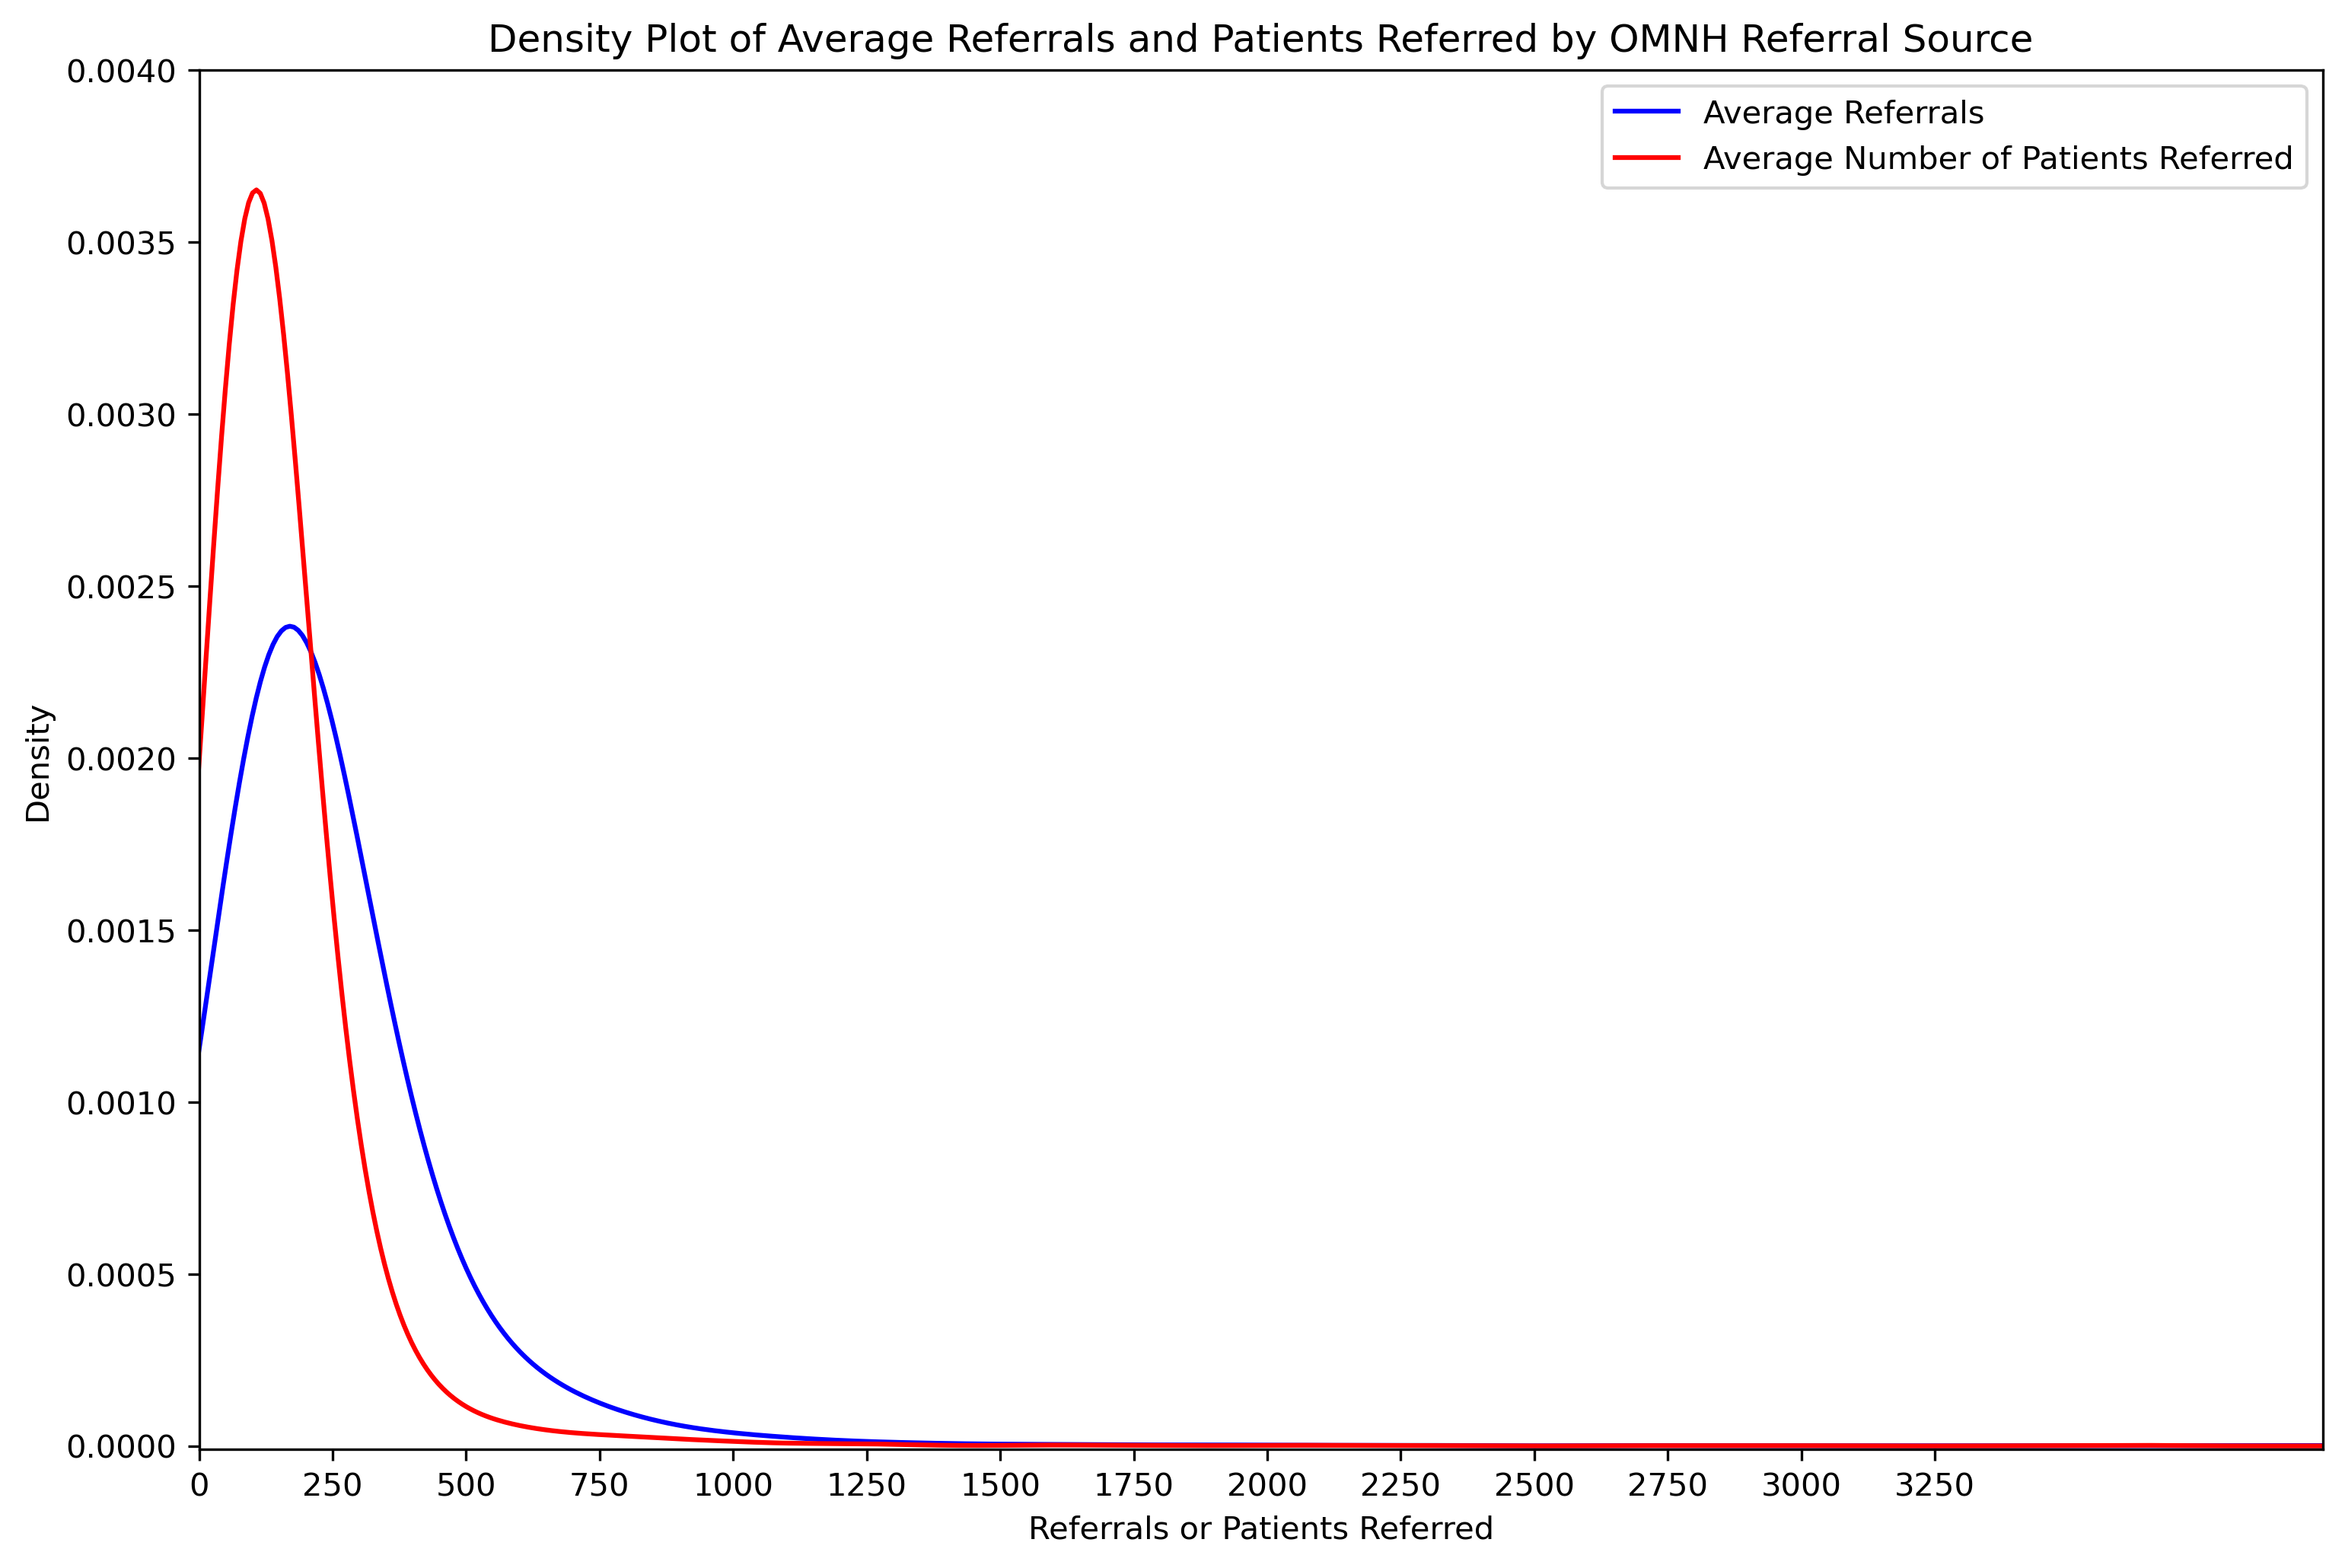

In [4]:
# Plot distributions of patient counts and referral counts.
ymin = -0.00001
ymax = 0.004
plt.figure(figsize = (12, 8), dpi = 300)
density_transaction_count.plot(kind = 'density', bw_method = 0.5, color = 'b')
density_patient_count.plot(kind = 'density', bw_method = 0.5, color = 'r')
plt.xlim(0, max(density_transaction_count))
plt.xticks(np.arange(0,3500,250))
plt.ylim(bottom = ymin, top = ymax)
plt.xlabel("Referrals or Patients Referred")
plt.title('Density Plot of Average Referrals and Patients Referred by OMNH Referral Source')
plt.legend(labels = ['Average Referrals','Average Number of Patients Referred'])
plt.show();

In [5]:
# Obtain top 20 referral specialties from the patient count and referral count series.
transaction_specialty_count = (
    pd.DataFrame(density_transaction_count[density_transaction_count >= 500].reset_index())\
.merge(hospital_referrals.loc[:, hospital_referrals.columns != 'referrals'])\
.rename(columns = {'referrals':'average_referrals'})\
.value_counts('provider_taxonomy_code_display_name')[:20]\
    .to_frame()\
    .reset_index()\
    .rename(columns = {0: 'Count'})\
    .sort_values('Count')
)

patient_specialty_count = (
    pd.DataFrame(density_patient_count[density_patient_count >= 500].reset_index())\
.merge(hospital_referrals.loc[:, hospital_referrals.columns != 'number_of_patients'])\
.rename(columns = {'number_of_patients':'average_number_of_patients'})\
.value_counts('provider_taxonomy_code_display_name')[:20]\
    .to_frame()\
    .reset_index()\
    .rename(columns = {0: 'Count'})\
    .sort_values('Count')
)

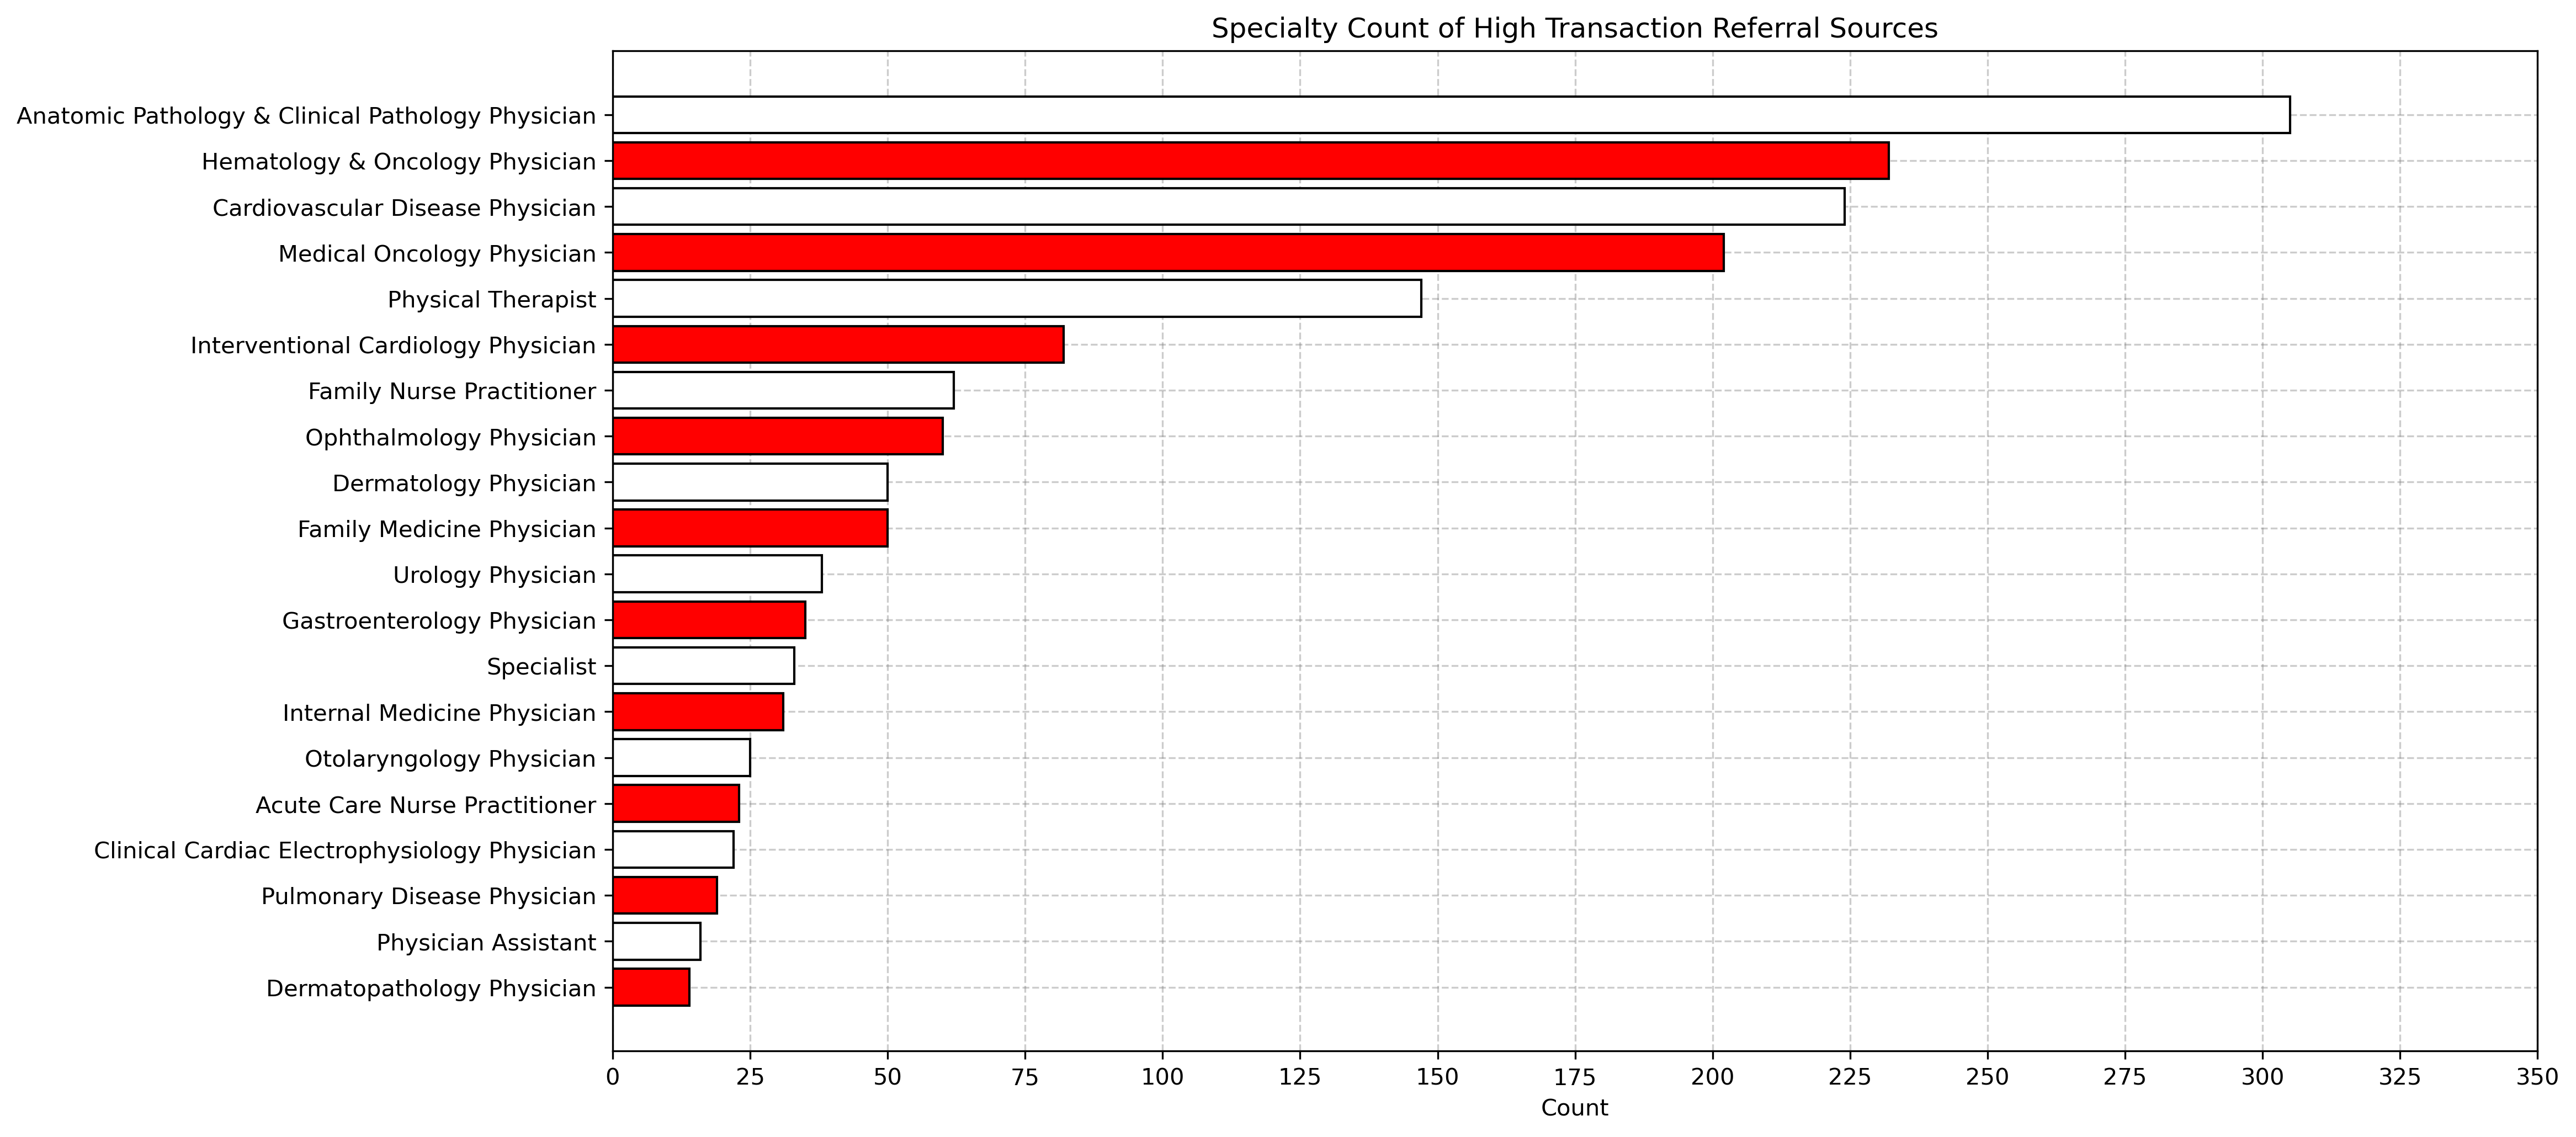

In [6]:
# Then plot counts with barplots.
# Consider removing nurse practitioners/nurses and adding specialties on same level.
fig, ax = plt.subplots(figsize = (15, 8), dpi = 300)
ax.barh(y = transaction_specialty_count['provider_taxonomy_code_display_name'].str.title(),
        width = transaction_specialty_count['Count'],
        edgecolor = 'k',
        color = ['red','white'])
ax.set_axisbelow(True)
ax.grid(color = 'gray', linestyle = '--', alpha = 0.4)
plt.xlim(0,350)
plt.xticks(np.arange(0,375,25))
plt.title('Specialty Count of High Transaction Referral Sources')
plt.xlabel('Count')
plt.show();

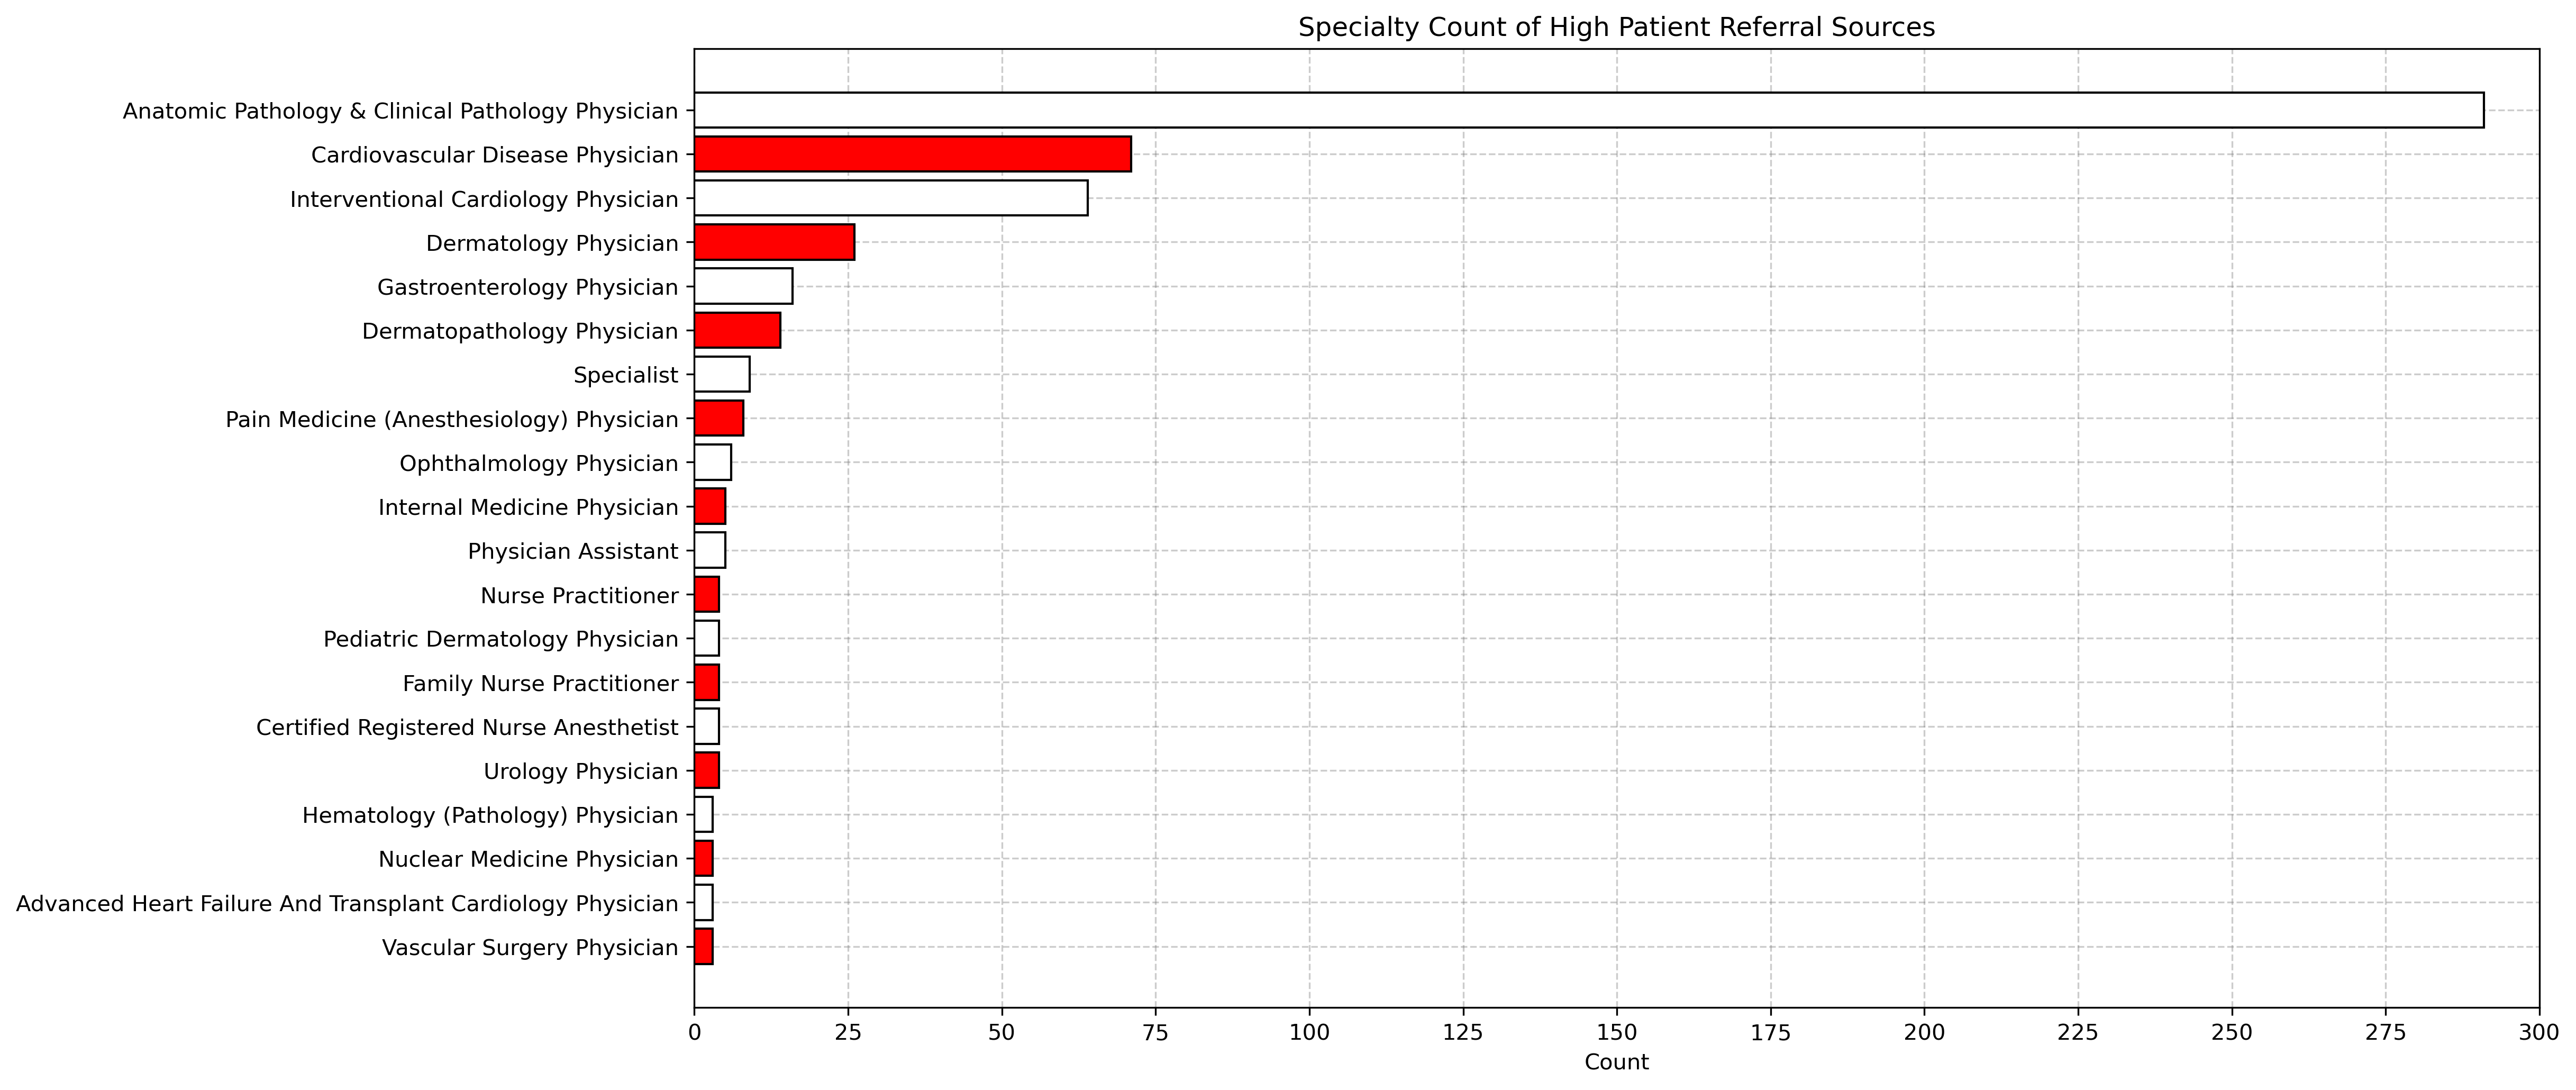

In [7]:
fig, ax = plt.subplots(figsize = (15, 8), dpi = 300)
ax.barh(y = patient_specialty_count['provider_taxonomy_code_display_name'].str.title(),
        width = patient_specialty_count['Count'],
        edgecolor = 'k',
        color = ['red','white'])
ax.set_axisbelow(True)
ax.grid(color = 'gray', linestyle = '--', alpha = 0.4)
plt.xlim(0,300)
plt.xticks(np.arange(0,325,25))
plt.title('Specialty Count of High Patient Referral Sources')
plt.xlabel('Count')
plt.show();

In [8]:
# Create dataframe for log-transformed transaction counts and patient counts.
hexbin_df = (
    density_transaction_count\
    .reset_index()\
    .merge(density_patient_count\
           .reset_index())[['referrals','number_of_patients']]\
    .assign(transaction_count = lambda df: df.apply(lambda x: np.log10(x['referrals']), axis = 1),
          patient_count = lambda df: df.apply(lambda x: np.log10(x['number_of_patients']), axis = 1))
)

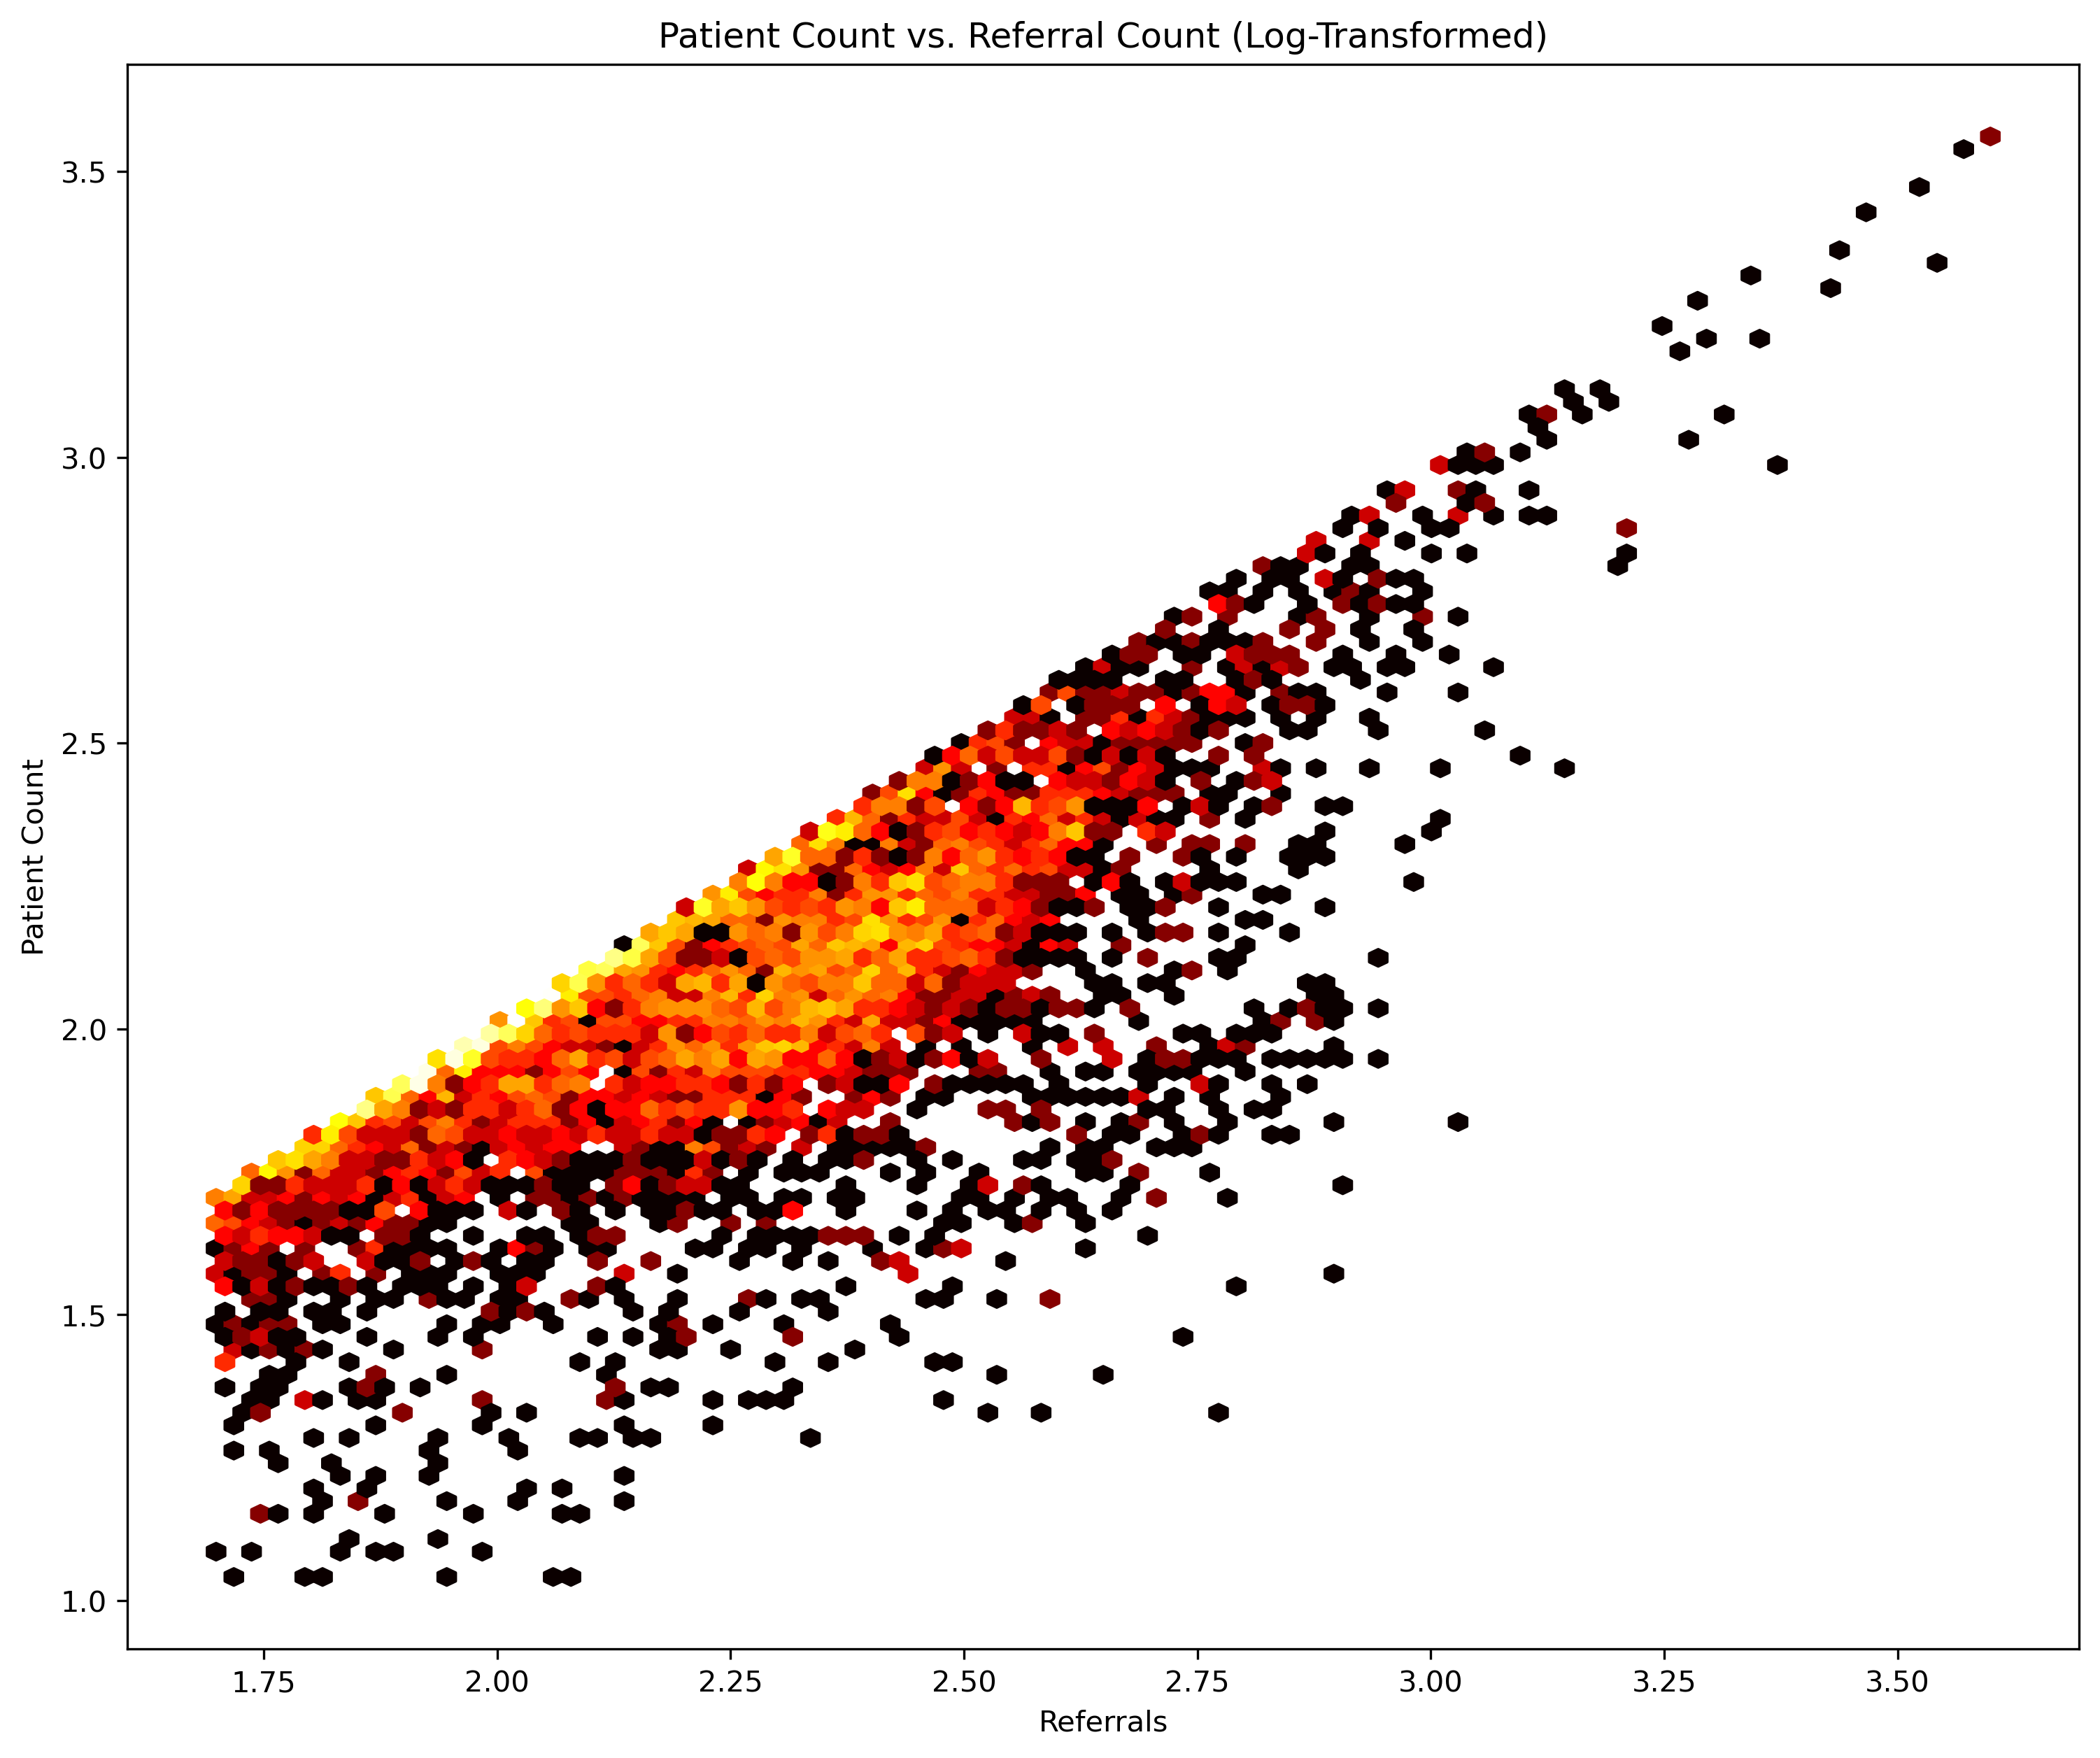

In [9]:
# Plot hexbin graph with transaction counts and patient counts showing almost perfect correlation.
plt.figure(figsize = (12,10), dpi = 300)
plt.hexbin(hexbin_df['transaction_count'],
          hexbin_df['patient_count'],
          cmap = 'hot',
          bins = 'log')
plt.title('Patient Count vs. Referral Count (Log-Transformed)')
plt.xlabel('Referrals')
plt.ylabel('Patient Count')
plt.show()

In [10]:
# Generate zipcodes of facilities and compare referrals to facilitiees by zipcode against the number of unique facilities
# in that zipcode weighted by zipcode population.
with open('data/census.json', 'r') as myfile:
    data = myfile.read()
api_key = json.loads(data)

c = Census(api_key['api_key'])
zip_data = c.acs5.state_zipcode(('NAME','B01003_001E'), states.TN.fips, zcta = '*')
zipcode_pop = (
    pd.DataFrame\
    .from_records(zip_data)[['B01003_001E','zip code tabulation area']]\
    .rename(columns = {'B01003_001E':'population',
                      'zip code tabulation area':'zipcode'})\
)

zipcode_pop['zipcode'] = zipcode_pop['zipcode'].astype(str)

hospital_referrals['facility_city_zipcode'] = hospital_referrals['facility_address'].str.extract('(\\d{5})')

referrals_and_facilities_by_zipcode = (
    pd.merge(hospital_referrals\
             .groupby('facility_city_zipcode')['referrals']\
             .sum()\
             .reset_index(),
             hospital_referrals\
             .groupby('facility_city_zipcode')['facility_entity_name']\
             .nunique()\
             .reset_index(),
             on = 'facility_city_zipcode')\
    .merge(zipcode_pop,
           left_on = 'facility_city_zipcode',
           right_on = 'zipcode')\
    .rename(columns = {'facility_entity_name':'facility_count',
                      'referrals':'total_referrals'})\
    .iloc[:,0:4]
)

referrals_and_facilities_by_zipcode['total_referrals'] = (
    referrals_and_facilities_by_zipcode['total_referrals']/referrals_and_facilities_by_zipcode['population'] * 1000
)

referrals_and_facilities_by_zipcode['facility_count'] = (
    referrals_and_facilities_by_zipcode['facility_count']/referrals_and_facilities_by_zipcode['population'] * 1000
)

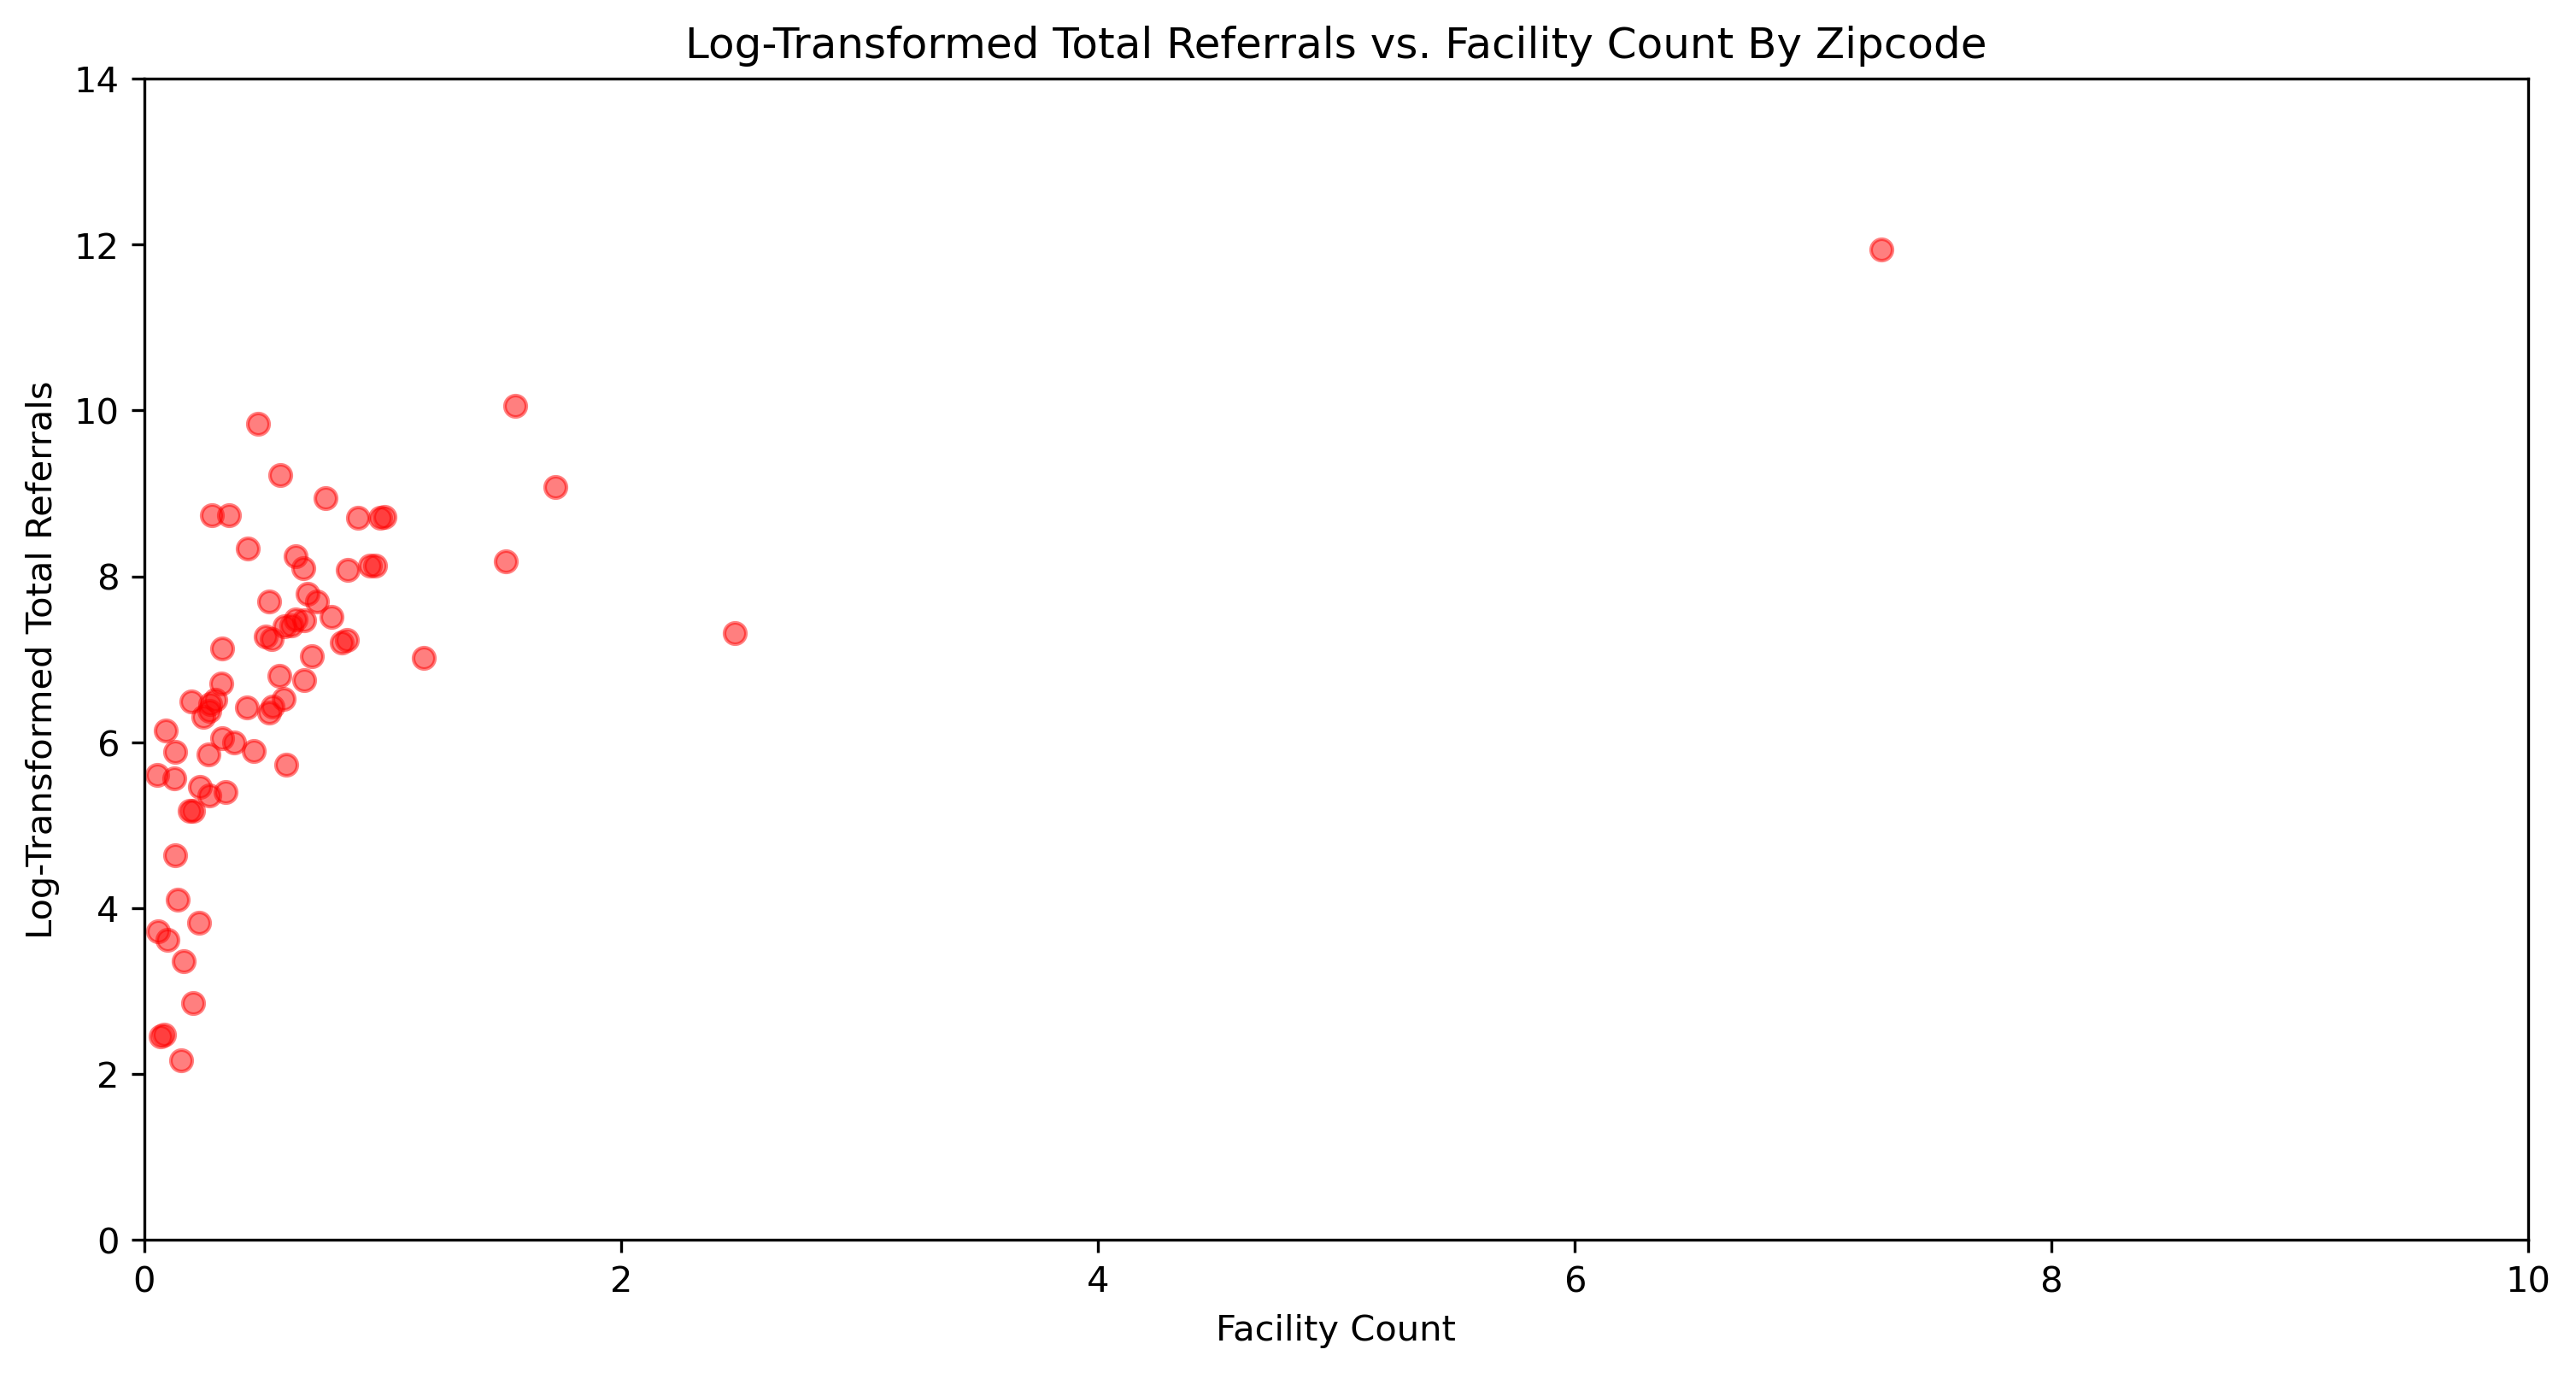

In [11]:
# Plot total referrals by zipcode against count of distinct facilities in that zipcode.
plt.figure(figsize = (12,6), dpi = 300)
plt.scatter(x = referrals_and_facilities_by_zipcode['facility_count'], 
            y = np.log(referrals_and_facilities_by_zipcode['total_referrals']),
           alpha = 0.5,
           color = 'red')
plt.title('Log-Transformed Total Referrals vs. Facility Count By Zipcode')
plt.xlabel('Facility Count')
plt.ylabel('Log-Transformed Total Referrals')
plt.xlim(0,10)
plt.ylim(0,14)
plt.show();

In [12]:
# Generate zipcodes and ratio of referrals out than referrals in.
hospital_referrals['facility_city_zipcode'] = hospital_referrals['facility_address'].str.extract('(\\d{5})')
hospital_referrals['provider_city_zipcode'] = hospital_referrals['provider_address'].str.extract('(\\d{5})')

zipcode_referrals = (
    pd.merge(hospital_referrals\
         .groupby('facility_city_zipcode')['referrals']\
         .sum()\
         .reset_index(),
         hospital_referrals\
         .groupby('provider_city_zipcode')['referrals']\
         .sum()\
         .reset_index(),
         left_on = 'facility_city_zipcode',
         right_on = 'provider_city_zipcode',
        suffixes = ('_facility','_provider'))
)

zipcode_referrals = (
    zipcode_referrals\
    .assign(referral_ratio = lambda df: df['referrals_provider']/df['referrals_facility'])\
    .rename(columns = {'facility_city_zipcode':'city_zipcode'})\
    [['city_zipcode','referral_ratio', 'referrals_provider', 'referrals_facility']]\
    .sort_values('referral_ratio', ascending = False)
)

zipcode_referrals = (
    pd.merge(zipcode_referrals,
             zipcode_pop,
             left_on = 'city_zipcode',
             right_on = 'zipcode')
)

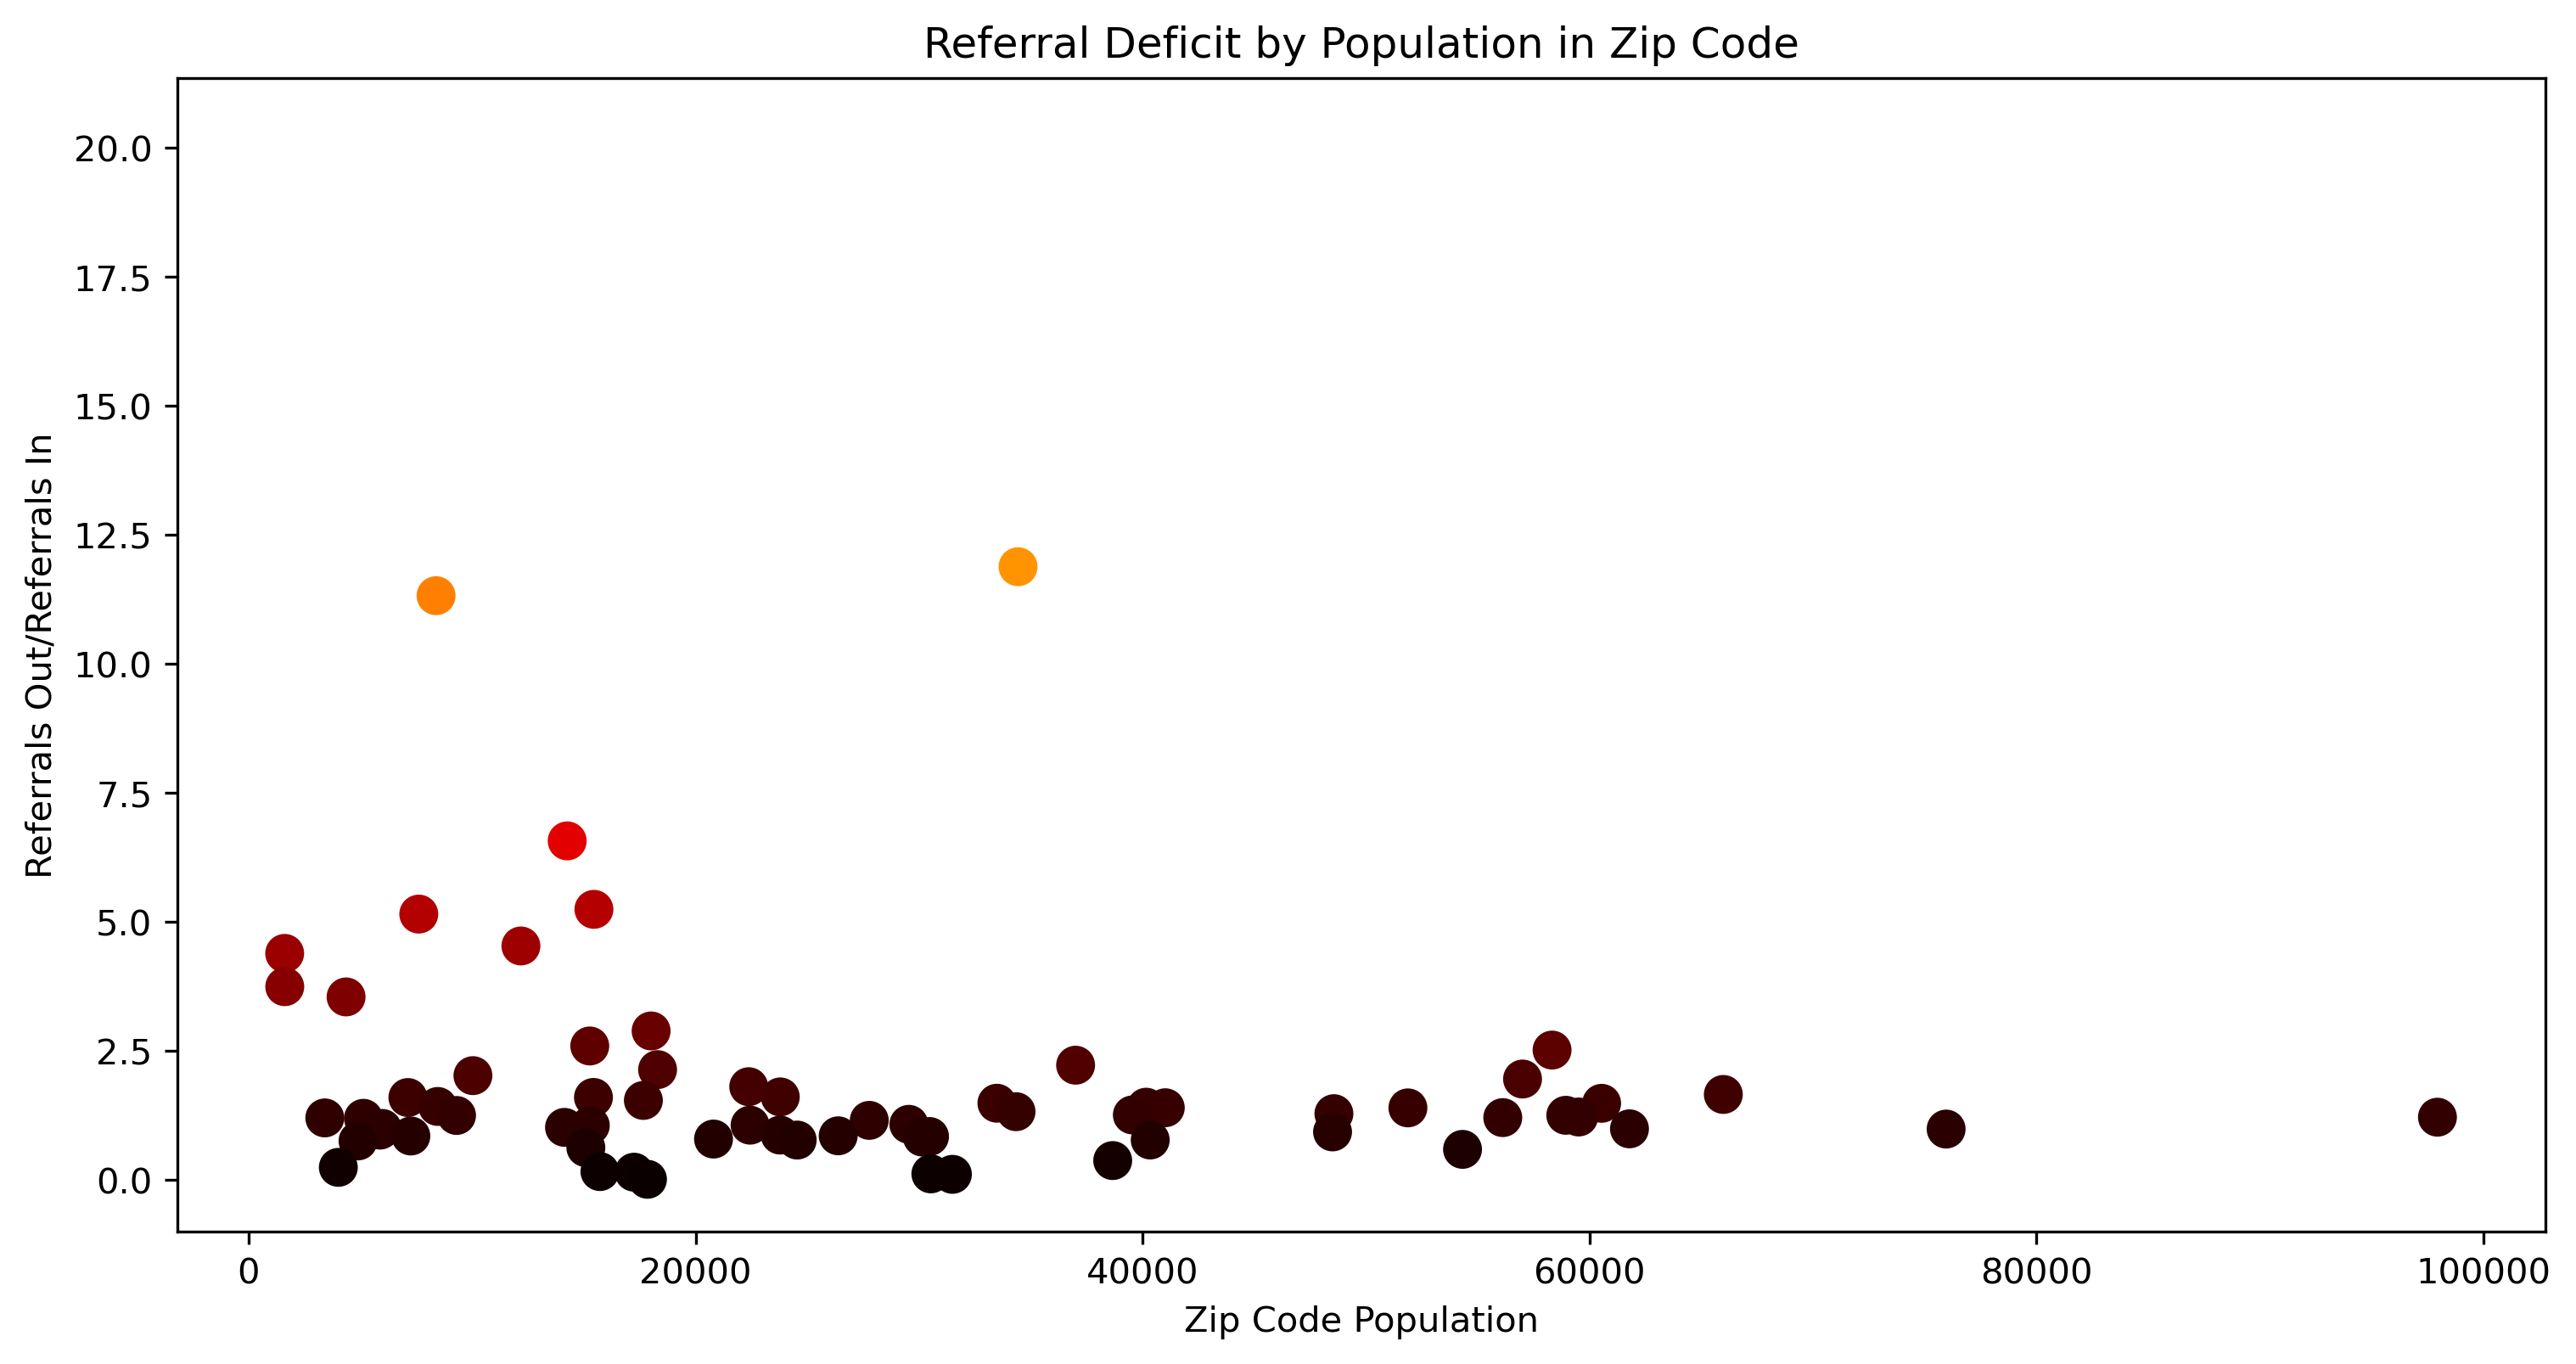

In [13]:
# Plot total referrals by zipcode against count of distinct facilities in that zipcode.
plt.figure(figsize = (12,6), dpi = 300)
plt.scatter(x = zipcode_referrals['population'], 
            y = zipcode_referrals['referral_ratio'],
            c = zipcode_referrals['referral_ratio'],
            cmap = 'hot',
            marker = 'o',
            linewidths = 5)
plt.title("Referral Deficit by Population in Zip Code")
plt.ylabel("Referrals Out/Referrals In")
plt.xlabel("Zip Code Population")
plt.show();